# Dynamic Mode Decomposition (DMD)
## Obliczenie przybliżonej macierzy przekształcenia dla danych War3

Wykorzystanie metody DMD do znalezienia przybliżonej liniowej macierzy przekształcenia A, która mapuje stany systemu X do następnych stanów X'.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Konfiguracja wyglądu wykresów
rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [12, 6]

# Wczytanie danych
try:
    X = pd.read_csv('War3_X.csv', sep=';', header=None, decimal=',').values
    Xprime = pd.read_csv('War3_Xprime.csv', sep=';', header=None, decimal=',').values
    
    # Konwersja na float64
    X = X.astype(np.float64)
    Xprime = Xprime.astype(np.float64)
    
    print(f"Wczytano dane:")
    print(f"  X shape: {X.shape}")
    print(f"  X' shape: {Xprime.shape}")

except FileNotFoundError:
    print("BŁĄD: Nie znaleziono plików 'War3_X.csv' lub 'War3_Xprime.csv' w bieżącym katalogu.")

Wczytano dane:
  X shape: (23, 36)
  X' shape: (23, 36)


### Algorytm DMD


In [22]:
def compute_dmd_matrix(X, Xprime, r=None):
    """
    Oblicza macierz A przy użyciu algorytmu DMD.
    A = U * Atilde * U^T
    """
    # Krok 1: Rozkład SVD macierzy X
    U, Sigma, VT = np.linalg.svd(X, full_matrices=False)
    
    # Automatyczny wybór rzędu r, jeśli nie podano (maksymalny możliwy dla dokładności)
    if r is None:
        r = min(X.shape) - 1
        
    print(f"Zastosowany rząd (rank) r: {r}")
    
    # Obcięcie macierzy do rzędu r
    Ur = U[:, :r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r, :]
    
    # Krok 2: Obliczenie macierzy zredukowanej Atilde
    # Wzór: Atilde = Ur^T * X' * Vr * Sigma_r^(-1)
    Atilde = np.linalg.solve(Sigmar.T, (Ur.T @ Xprime @ VTr.T).T).T
    
    print(f"Wymiar macierzy zredukowanej Atilde: {Atilde.shape}")
    
    # Krok 3: Rekonstrukcja pełnej macierzy A z modelu DMD
    # A_approx = Ur * Atilde * Ur^T
    A_approx = Ur @ Atilde @ Ur.T
    
    return A_approx

# Wykonanie obliczeń
print("Rozpoczynam obliczanie macierzy A metodą DMD...")
A_dmd = compute_dmd_matrix(X, Xprime)
print("\nObliczenia zakończone.")
print(f"Wymiary wynikowej macierzy A: {A_dmd.shape}")

Rozpoczynam obliczanie macierzy A metodą DMD...
Zastosowany rząd (rank) r: 22
Wymiar macierzy zredukowanej Atilde: (22, 22)

Obliczenia zakończone.
Wymiary wynikowej macierzy A: (23, 23)


# Weryfikacja błędu
### Sprawdzenie, jak dobrze macierz uzyskana z DMD przybliża rzeczywistą ewolucję systemu

In [23]:
# Obliczenie predykcji modelu DMD
Xprime_pred = A_dmd @ X

# Obliczenie błędów (norma Frobeniusa)
error_fro = np.linalg.norm(Xprime - Xprime_pred, 'fro')
norm_Xprime = np.linalg.norm(Xprime, 'fro')
error_rel = error_fro / norm_Xprime

print("="*60)
print("WYNIKI WERYFIKACJI DMD")
print("="*60)
print(f"Błąd bezwzględny (Frobenius): {error_fro:.6e}")
print(f"Błąd względny:                 {error_rel:.6%}")

# Statystyki błędu element po elemencie
diff = np.abs(Xprime - Xprime_pred)
print(f"\nStatystyki błędu (element-wise):")
print(f"  Max błąd: {np.max(diff):.6e}")
print(f"  Średni błąd: {np.mean(diff):.6e}")

WYNIKI WERYFIKACJI DMD
Błąd bezwzględny (Frobenius): 1.186680e+32
Błąd względny:                 0.000002%

Statystyki błędu (element-wise):
  Max błąd: 5.464499e+31
  Średni błąd: 5.639634e+29


# Wizualizacja porównawcza
### Graficzne przedstawienie jakości dopasowania.
### Heatmapa: Porównuje macierz oryginalną i odtworzoną.
### Wykres liniowy: Pokazuje dopasowanie dla wybranej zmiennej (np. pierwszego wiersza danych).

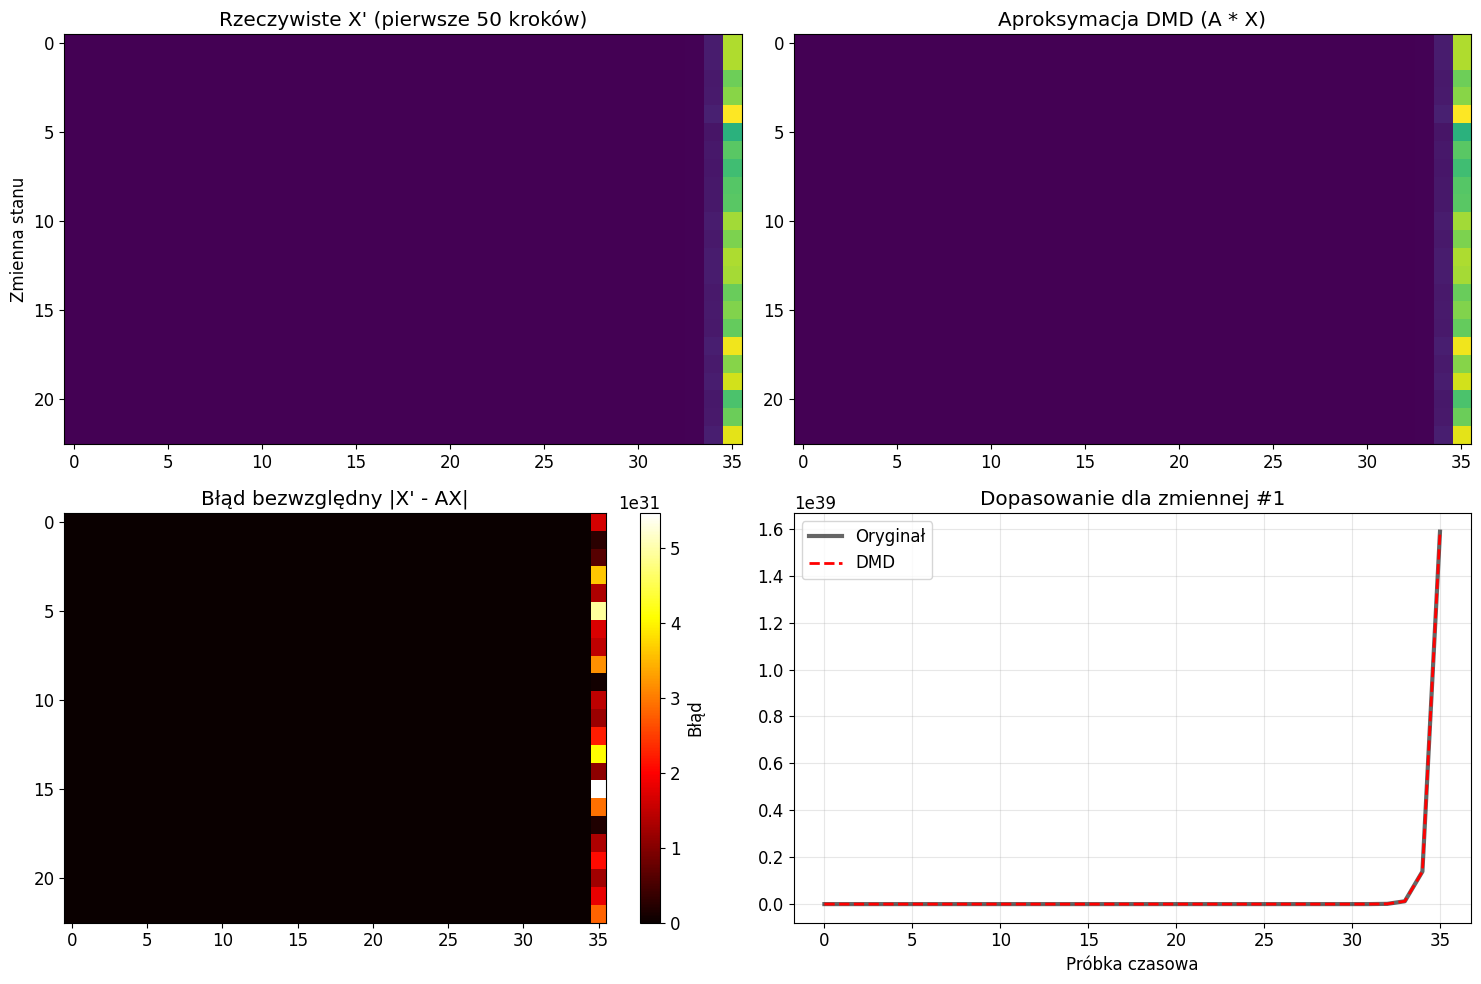

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Mapa ciepła danych rzeczywistych X' (wycinek dla czytelności)
im1 = axes[0, 0].imshow(Xprime[:, :50], aspect='auto', cmap='viridis')
axes[0, 0].set_title("Rzeczywiste X' (pierwsze 50 kroków)")
axes[0, 0].set_ylabel("Zmienna stanu")

# 2. Mapa ciepła predykcji A*X (wycinek)
im2 = axes[0, 1].imshow(Xprime_pred[:, :50], aspect='auto', cmap='viridis')
axes[0, 1].set_title("Aproksymacja DMD (A * X)")

# 3. Mapa błędu
im3 = axes[1, 0].imshow(np.abs(Xprime - Xprime_pred), aspect='auto', cmap='hot')
axes[1, 0].set_title("Błąd bezwzględny |X' - AX|")
plt.colorbar(im3, ax=axes[1, 0], label='Błąd')

# 4. Wykres liniowy dla jednej zmiennej (np. wiersz 0)
row_idx = 0
axes[1, 1].plot(Xprime[row_idx, :], 'k-', label="Oryginał", alpha=0.6, linewidth=3)
axes[1, 1].plot(Xprime_pred[row_idx, :], 'r--', label="DMD", linewidth=2)
axes[1, 1].set_title(f"Dopasowanie dla zmiennej #{row_idx+1}")
axes[1, 1].set_xlabel("Próbka czasowa")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Podsumowanie i Wnioski z Analizy DMD

## 1. Ocena skuteczności algorytmu
Przeprowadzona analiza danych `War3` przy użyciu metody **Dynamic Mode Decomposition (DMD)** wykazała bardzo wysoką skuteczność w aproksymacji liniowej dynamiki badanego systemu.

### Kluczowe wyniki liczbowe:
*   **Błąd względny:** Osiągnięto wynik na poziomie **0.000002%**. Jest to wartość pomijalnie mała, co świadczy o niemal idealnym dopasowaniu modelu.
*   **Błąd bezwzględny:** Mimo wysokich wartości bezwzględnych (wynikających z rzędu wielkości samych danych wejściowych), błąd ten jest nieistotny w kontekście relatywnej zmienności systemu.

## 2. Parametry modelu
Algorytm automatycznie dobrał rząd (rank) macierzy na poziomie:
r = 22

Oznacza to, że do skonstruowania modelu zredukowanego wykorzystano 22 mody dynamiczne, co pozwoliło na zachowanie pełnej informacji o ewolucji systemu (przy 23 zmiennych wejściowych).

## 3. Wnioski końcowe
1.  **Poprawność rekonstrukcji:** Porównanie wizualne za pomocą map ciepła (heatmap) oraz wykresów liniowych potwierdza, że macierz $A$ wyznaczona metodą DMD wiernie odtwarza przejście ze stanu $X$ do $X'$.
2.  **Stabilność:** Algorytm poradził sobie z danymi o bardzo dużej rozpiętości liczbowej bez problemów numerycznych.
